That last notebook got messy so I'm making a new cleaner one that will enable me to sample over both emulators simultaneously. 

In [1]:
import matplotlib
#matplotlib.use('Agg')
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
#sns.set()

In [2]:
import numpy as np
import h5py
from chainconsumer import ChainConsumer
#from corner import corner
from ast import literal_eval
from pearce.emulator import LemonPepperWet
from os import path
from scipy.linalg import inv

 /u/ki/swmclau2/.conda/envs/hodemulator/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning:numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.


In [3]:
fname = '/u/ki/swmclau2/des/PearceMCMC/HOD_1_1_rmin_1.0_Knn1CDF_v3.hdf5'

In [4]:
f = h5py.File(fname, 'r')

In [5]:
tf = f.attrs['training_file']
fixed_params = literal_eval(f.attrs['fixed_params'])
if 'rmin' in fixed_params:
    del fixed_params['rmin']
emu_hps = literal_eval(f.attrs['emu_hps'])

In [6]:
tf

array(['/u/ki/swmclau2/des/Aemulators/knn_1_cdf_hsab/PearceKNN1CDFCutHSABCosmo.hdf5'],
      dtype='|S75')

In [7]:
fixed_params = fixed_params[0] if type(fixed_params) is list else fixed_params

In [8]:
emus = []
for t in tf:
    print t
    emus.append(LemonPepperWet(t, fixed_params = fixed_params))#, hyperparams = emu_hps) )

/u/ki/swmclau2/des/Aemulators/knn_1_cdf_hsab/PearceKNN1CDFCutHSABCosmo.hdf5
Mean -1.3546453325152716
Std 1.0


In [9]:
pnames = emus[0].get_param_names()[7:]
for p in pnames:
    print p, emus[0].get_param_bounds(p)

mean_occupation_centrals_assembias_param1 (-1.0, 1.0)
logM0 (12.6, 13.6)
sigma_logM (0.05, 0.5)
mean_occupation_satellites_assembias_param1 (-1.0, 1.0)
logM1 (13.7, 14.7)
alpha (0.7, 1.3)
conc_gal_bias (0.5, 2.0)


In [10]:
reorder_idxs = [5,1,0,6,2,3,4]

['ombh2',
 'omch2',
 'w0',
 'ns',
 'H0',
 'Neff',
 'sigma8',
 'mean_occupation_centrals_assembias_param1',
 'logM0',
 'sigma_logM',
 'mean_occupation_satellites_assembias_param1',
 'logM1',
 'alpha',
 'conc_gal_bias']

In [11]:
emu = emus[0]

In [12]:
emu.y.shape

(40, 1000, 15)

In [13]:
emu.get_param_names()[7:]

['mean_occupation_centrals_assembias_param1',
 'logM0',
 'sigma_logM',
 'mean_occupation_satellites_assembias_param1',
 'logM1',
 'alpha',
 'conc_gal_bias']

In [14]:
idxs = np.argsort(emu.x1[:,1])

In [15]:
cmaps = sns.cubehelix_palette(n_colors = 40)

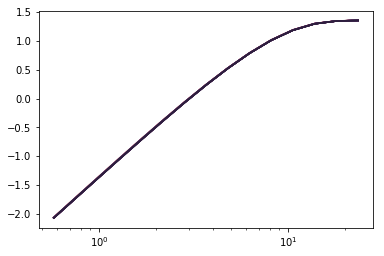

In [16]:
for i,c in zip(idxs, cmaps):#[20:25]:
    plt.plot(emu.scale_bin_centers, emu.y[i,9],color=c,  label = i );
plt.xscale('log')
#plt.legend(loc='best')

In [17]:
np.where(emu.y[:,9][:,0]<0.5)[0]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39])

In [18]:
emu.get_param_names()[:7]

['ombh2', 'omch2', 'w0', 'ns', 'H0', 'Neff', 'sigma8']

In [19]:
chain_pnames = f.attrs['param_names']

In [20]:
n_walkers = f.attrs['nwalkers']

In [21]:
n_burn =0
chain = f['chain'][n_burn*n_walkers:, :]
lnprob = f['lnprob'][n_burn*n_walkers:]

In [22]:
try:
    rmin = eval(f.attrs['fixed_params'])['rmin']
except:
    rmin = 0

In [23]:
n_params = chain.shape[1] if len(chain.shape) > 1 else 1

In [24]:
print chain.shape, chain.shape[0]/n_walkers

(2143250, 14) 8573


In [25]:
c = ChainConsumer()
chain = chain.reshape((-1, n_walkers, chain.shape[1]))
chain = chain.reshape((-1, chain.shape[2]), order = 'F')
lnprob = lnprob.reshape((-1, n_walkers)).reshape((-1,), order = 'F')
lnprob[~np.isfinite(lnprob)] = -1e9
c.add_chain(chain, parameters=list(chain_pnames), walkers = n_walkers, posterior=lnprob)


In [26]:
MAP_dict = c.analysis.get_max_posteriors()

In [27]:
#fixed_params = eval(f.attrs['chain_fixed_params'])
#fixed_params.update(eval(f.attrs['sim'])['cosmo_params'])

In [28]:
MAP_dict.update(fixed_params)

In [29]:
MAP_dict

{'H0': 65.194885,
 'Neff': 4.2552752,
 'alpha': 0.9815507,
 'conc_gal_bias': 0.9278828,
 'logM0': 13.211898,
 'logM1': 14.002002,
 'mean_occupation_centrals_assembias_param1': -0.41920412,
 'mean_occupation_satellites_assembias_param1': -0.048989765,
 'ns': 0.9548922,
 'ombh2': 0.022214372,
 'omch2': 0.12219822,
 'sigma8': 0.7831468,
 'sigma_logM': 0.22673719,
 'w0': -0.97155195,
 'z': 0.0}

In [30]:
MAP_pred = [emu.emulate_wrt_r(MAP_dict, r_bin_centers=emu.scale_bin_centers).squeeze() for emu in emus]#)
#MAP_pred = MAP_pred.reshape((len(emus), -1))

In [31]:
hod_idxs = np.array(range(7, len(chain_pnames)))
cosmo_idxs = np.array(range(7))

In [32]:
if chain.shape[1] == 7:
    cosmo_chain = chain
else:
    hod_chain = chain[:,7:]#[:, hod_idxs]
    cosmo_chain = chain[:,:7]#[:, cosmo_idxs]

In [33]:
from pearce.mocks import cat_dict
cosmo_params = {}

In [34]:
cosmo_params['boxno'] = 1#5
cosmo_params['realization'] = 1

In [35]:
cat = cat_dict['testbox'](**cosmo_params)#construct the specified catalog!

In [36]:
cpv = cat._get_cosmo_param_names_vals()

cat_val_dict =  {key: val for key, val in zip(cpv[0], cpv[1])}

In [37]:
cat_val_dict

{'H0': 65.7317,
 'Neff': 3.2,
 'ns': 0.971515,
 'ombh2': 0.022762900000000003,
 'omch2': 0.11283,
 'sigma8': 0.7542319000000001,
 'w0': -0.861513}

In [38]:
emu.get_param_names()

['ombh2',
 'omch2',
 'w0',
 'ns',
 'H0',
 'Neff',
 'sigma8',
 'mean_occupation_centrals_assembias_param1',
 'logM0',
 'sigma_logM',
 'mean_occupation_satellites_assembias_param1',
 'logM1',
 'alpha',
 'conc_gal_bias']

In [39]:
true_param_dict = cat_val_dict.copy()
hod_params = {'alpha': 1.0, 'conc_gal_bias': 1.0, 'logM0': 13.0,'logM1': 14.0,\
              'sigma_logM': 0.2}#sim_info['hod_params']
#hod_params = {'alpha': 1.09, 'conc_gal_bias': 1.0, 'logM0': 13.4,
#              'logM1': 14.6, 'sigma_logM': 0.6}#sim_info['hod_params']
#hod_params = {'conc_gal_bias':1.0}
#hod_params = {'alpha':0.95, 'conc_gal_bias': 1.0, 'logM0': 13.5,
#              'logM1': 14.2, 'sigma_logM': 0.4}
#plot_hod_true_vals = [0.4, 13.5, 14.2, 0.95, 1.0]

#plot_hod_true_vals = [0.2, 13.0, 14.0, 1.0, 1.0]

hod_params['mean_occupation_centrals_assembias_param1'] = 0.0#25
hod_params['mean_occupation_satellites_assembias_param1'] = -0.0#75
#hod_params['mean_occupation_centrals_assembias_slope1'] = 3.0
#hod_params['mean_occupation_satellites_assembias_slope1'] = 3.0
#hod_params['mean_occupation_centrals_assembias_corr1'] = 0.0#25
#hod_params['mean_occupation_satellites_assembias_corr1'] = -0.0#75
#for pname in emu.get_param_names():
#    if 'mean_occupation' in pname:
#        hod_params[pname] = 0.0

for hp, hv in hod_params.iteritems():
#for hp, hv in MAP_dict.iteritems():
    if hp == 'logMmin':
        continue
    elif hp in true_param_dict: #don't overwrite the correct cosmology
        continue

    true_param_dict[hp] = hv

#for hp, hv in MAP_dict.iteritems():
#    if hp == 'logMmin':
#        continue
    #elif hp in true_param_dict: #don't overwrite the correct cosmology
    #    continue
#    elif hp in true_param_dict: #don't overwrite the correct cosmology
#        true_param_dict[hp] = hv
    
true_param_dict['conc_gal_bias'] = 1.0
true_pred = emu.emulate_wrt_r(true_param_dict)[0]

In [40]:
true_param_dict

{'H0': 65.7317,
 'Neff': 3.2,
 'alpha': 1.0,
 'conc_gal_bias': 1.0,
 'logM0': 13.0,
 'logM1': 14.0,
 'mean_occupation_centrals_assembias_param1': 0.0,
 'mean_occupation_satellites_assembias_param1': -0.0,
 'ns': 0.971515,
 'ombh2': 0.022762900000000003,
 'omch2': 0.11283,
 'sigma8': 0.7542319000000001,
 'sigma_logM': 0.2,
 'w0': -0.861513}

In [41]:
MAP_dict

{'H0': 65.194885,
 'Neff': 4.2552752,
 'alpha': 0.9815507,
 'conc_gal_bias': 0.9278828,
 'logM0': 13.211898,
 'logM1': 14.002002,
 'mean_occupation_centrals_assembias_param1': -0.41920412,
 'mean_occupation_satellites_assembias_param1': -0.048989765,
 'ns': 0.9548922,
 'ombh2': 0.022214372,
 'omch2': 0.12219822,
 'sigma8': 0.7831468,
 'sigma_logM': 0.22673719,
 'w0': -0.97155195,
 'z': 0.0}

In [42]:
true_data = f['data'][()].flatten()

In [43]:
true_data[:-7]

array([0.00035448, 0.00076424, 0.0016436 , 0.00352052, 0.00749887,
       0.01582761, 0.03289377, 0.06671295])

In [44]:
y = true_data
true_data = true_data.reshape((len(emus), -1))

In [45]:
rbc = emu.scale_bin_centers#[-len(emu.scale_bin_centers):]

In [46]:
cov = f['cov'][()]
yerr = np.sqrt(np.diag(cov))#.reshape((len(emus), -1))
#yerr = [yerr[:emus[0].n_bins].squeeze(), yerr[emus[0].n_bins:emus[0].n_bins+emus[1].n_bins].squeeze(), yerr[emus[0].n_bins+emus[1].n_bins:].squeeze()]

In [47]:
true_param_dict

{'H0': 65.7317,
 'Neff': 3.2,
 'alpha': 1.0,
 'conc_gal_bias': 1.0,
 'logM0': 13.0,
 'logM1': 14.0,
 'mean_occupation_centrals_assembias_param1': 0.0,
 'mean_occupation_satellites_assembias_param1': -0.0,
 'ns': 0.971515,
 'ombh2': 0.022762900000000003,
 'omch2': 0.11283,
 'sigma8': 0.7542319000000001,
 'sigma_logM': 0.2,
 'w0': -0.861513}

In [48]:
true_pred = emus[0].emulate_wrt_r(true_param_dict).squeeze()

In [49]:
true_pred.shape

(15,)

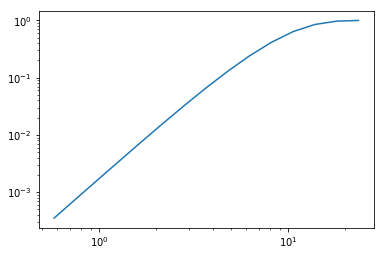

In [50]:
plt.plot(emus[0].scale_bin_centers, 10**true_pred.T)
plt.xscale('log')
plt.yscale('log')

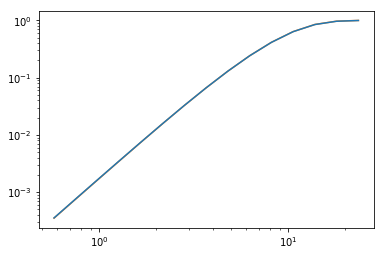

In [51]:
#fig = plt.figure(figsize = (12,5))
for i in xrange(len(emus)):
    #plt.subplot(1,3,i+1)
    rbc = emus[i].scale_bin_centers
    true_pred = emus[i].emulate_wrt_r(true_param_dict)[0].squeeze()
    plt.errorbar(rbc, true_data[i], yerr=yerr[i], label = 'Data')
    #plt.plot(rbc, 10**MAP_pred, label = 'MAP')
    plt.plot(rbc, 10**true_pred, label = 'Emu at Truth')

    plt.loglog()
    #plt.legend(loc='best')
plt.show();

In [52]:
yerr

array([1.24242174e-06, 1.74757140e-06, 3.37982284e-06, 7.60277262e-06,
       1.74146655e-05, 3.89380388e-05, 8.42486755e-05, 1.74956608e-04,
       3.44819661e-04, 6.33993311e-04, 1.04983738e-03, 1.47090220e-03,
       1.57018216e-03, 1.07718805e-03, 3.77298293e-04])

In [53]:
true_param_dict

{'H0': 65.7317,
 'Neff': 3.2,
 'alpha': 1.0,
 'conc_gal_bias': 1.0,
 'logM0': 13.0,
 'logM1': 14.0,
 'mean_occupation_centrals_assembias_param1': 0.0,
 'mean_occupation_satellites_assembias_param1': -0.0,
 'ns': 0.971515,
 'ombh2': 0.022762900000000003,
 'omch2': 0.11283,
 'sigma8': 0.7542319000000001,
 'sigma_logM': 0.2,
 'w0': -0.861513}

In [54]:
emus[i].emulate_wrt_r(true_param_dict)#.shape

array([[-3.45391286e+00, -3.12041768e+00, -2.78774220e+00,
        -2.45625416e+00, -2.12696664e+00, -1.80188956e+00,
        -1.48375527e+00, -1.17627467e+00, -8.84716817e-01,
        -6.16403610e-01, -3.81610151e-01, -1.94410386e-01,
        -6.97180792e-02, -1.21812868e-02,  3.77933167e-04]])

In [55]:
sherlock_pred = np.array([ -3.45391286e+00,  -3.12041768e+00,  -2.78774220e+00 , -2.45625416e+00
 , -2.12696664e+00,  -1.80188956e+00 , -1.48375527e+00,  -1.17627467e+00,
  -8.84716817e-01 , -6.16403610e-01 , -3.81610151e-01,  -1.94410386e-01,
  -6.97180792e-02 , -1.21812868e-02 ,  3.77933725e-04]
)

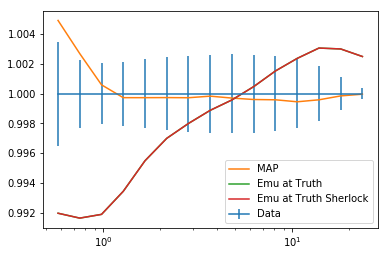

In [56]:
#fig = plt.figure(figsize = (12,5))
for i in xrange(len(emus)):

    #plt.subplot(1,3,i+1)
    #if i == 0:
    #    plt.title('Wp Ratio')
    #else:
    #    plt.title('Ds Ratio')
    rbc = emus[i].scale_bin_centers
    true_pred = emus[i].emulate_wrt_r(true_param_dict)[0].squeeze()
    plt.errorbar(rbc, np.ones_like(true_data[i]), yerr=yerr/true_data[i], label = 'Data')

    plt.plot(rbc, (10**MAP_pred[i])/true_data[i], label = 'MAP')
    plt.plot(rbc, (10**true_pred)/true_data[i], label = 'Emu at Truth')
    plt.plot(rbc, (10**sherlock_pred)/true_data[i], label = 'Emu at Truth Sherlock')

    #plt.vlines(rmin, 0.7, 1.3, alpha = 0.3)
    plt.legend(loc='best')
    plt.xscale('log')
    #plt.ylim([0.7, 1.3])
    
#plt.plot(rbc, x/true_data[0])
plt.show();

[0.99196004 0.99163142 0.99188338 0.99343543 0.99549091 0.99700011
 0.99800116 0.99888434 0.99958447 1.00048023 1.00153269 1.00237798
 1.00307374 1.00301462 1.00250524]
[-3.45391286e+00 -3.12041768e+00 -2.78774220e+00 -2.45625416e+00
 -2.12696664e+00 -1.80188956e+00 -1.48375527e+00 -1.17627467e+00
 -8.84716817e-01 -6.16403610e-01 -3.81610151e-01 -1.94410386e-01
 -6.97180792e-02 -1.21812868e-02  3.77933167e-04]


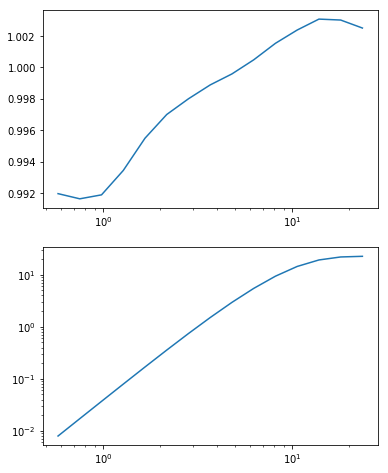

In [57]:
fig = plt.figure(figsize=(6,8))
plt.subplot(211)
plt.plot(rbc,(10**true_pred)/true_data[0])
print (10**true_pred)/true_data[0]
plt.xscale('log')
plt.subplot(212)
plt.plot(rbc, 10**(true_pred-emu._y_mean))
print true_pred
plt.loglog();

In [58]:
true_pred-emu._y_mean

array([-2.09926753, -1.76577235, -1.43309686, -1.10160882, -0.77232131,
       -0.44724423, -0.12910994,  0.17837066,  0.46992852,  0.73824172,
        0.97303518,  1.16023495,  1.28492725,  1.34246405,  1.35502327])

In [59]:
rmin_idxs = rbc>rmin#np.logical_and(rbc > rmin, true_data[0]>1e-2)

In [60]:
rmin_idxs

array([False, False, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

In [61]:
cov_rmin_idxs = rmin_idxs# np.r_[rmin_idxs, rmin_idxs]

In [62]:
true_pred= []
for i in xrange(len(emus)):
    true_pred.append(emus[i].emulate_wrt_r(true_param_dict).squeeze())
    
MAP_pred= []
for i in xrange(len(emus)):
    MAP_pred.append(emus[i].emulate_wrt_r(MAP_dict).squeeze())

In [63]:
print 'True Red. Chi2'
R = (10**np.hstack(true_pred).flatten()-np.hstack(true_data.squeeze()).flatten())
p#rint R/(true_data[:,rmin_idxs].flatten())
chi2 =  R.T.dot(inv(cov)).dot(R)
dof = len(chain_pnames)
Rt = R
print chi2/dof

True Red. Chi2
14.835541866038739


In [64]:
print 'Map Red. Chi2'
#R = (10**MAP_pred[:,rmin_idxs].flatten()-true_data[:,rmin_idxs].flatten())
R = (10**np.array(MAP_pred).squeeze()-np.hstack(true_data.squeeze()).flatten())

#print R/(np.hstack(true_data).flatten())

#chi2 =  R.T.dot(inv(cov[cov_rmin_idxs][:,cov_rmin_idxs])).dot(R)
chi2 =  R.T.dot(inv(cov)).dot(R)

dof = len(chain_pnames)
Rm = R
print chi2/dof

Map Red. Chi2
0.5911645280763315


In [65]:
def covtocorr(cov):
    diag = np.sqrt(np.diag(cov))
    return cov/np.outer(diag,diag)

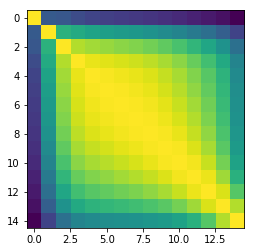

In [66]:
plt.imshow(covtocorr(cov))

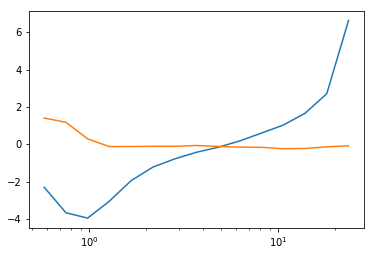

In [67]:
plt.plot(rbc, Rt/yerr)
plt.plot(rbc, Rm/yerr)
#plt.errorbar(rbc, np.zeros_like(rbc), yerr=yerr)
plt.xscale('log')

 /u/ki/swmclau2/.local/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning:Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
 /u/ki/swmclau2/.local/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning:Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
 /u/ki/swmclau2/.local/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning:Adding an axes using the same arguments as a previous

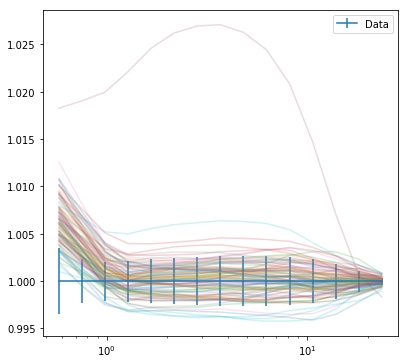

In [68]:
fig = plt.figure(figsize = (14,6))
chain_samples = np.random.choice(chain.shape[0], size = 100, replace = False)

for i in xrange(len(emus)):
    plt.subplot(1,2,i+1)
    plt.errorbar(rbc, np.ones_like(true_data[i]), yerr=yerr/true_data[i], label = 'Data')
    plt.xscale('log')
    #plt.ylim([0.8, 1.2])
    #plt.vlines(rmin, 0.8, 1.2, alpha = 0.3)
    
for sample in chain[chain_samples]:
    param_dict = dict(zip(chain_pnames, sample))
    param_dict.update(fixed_params)
    for i in xrange(len(emus)):
        plt.subplot(1,2,i+1)
        pred = emus[i].emulate_wrt_r(param_dict).squeeze()
        plt.plot(rbc, (10**pred)/true_data[i], alpha = 0.2)#, label = 'MAP')


plt.legend(loc='best')
plt.show();

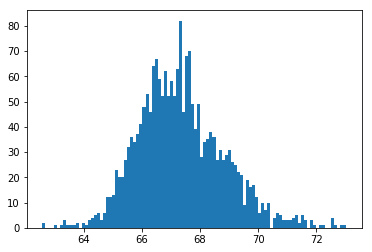

In [69]:
chain_samples = np.random.choice(chain.shape[0], size = 2000, replace = False)

plt.hist(chain[chain_samples][:,4], bins = 100);
plt.show();  

In [70]:
np.mean(chain[chain[:,4]<67],axis=0)

array([ 2.2294687e-02,  1.1728185e-01, -9.4202644e-01,  9.5976293e-01,
        6.6152855e+01,  3.5342610e+00,  7.8970766e-01, -4.3836087e-02,
        1.2996176e+01,  1.9989239e-01, -1.5586068e-01,  1.4006231e+01,
        1.0632112e+00,  8.6987090e-01], dtype=float32)

In [71]:
baseline_params2 = dict(zip(chain_pnames,
                        chain[np.logical_and(chain[:,4]>69,
                                            chain[:,4]<71,)][-1]))

In [72]:
chain_pnames

array(['ombh2', 'omch2', 'w0', 'ns', 'H0', 'Neff', 'sigma8',
       'mean_occupation_centrals_assembias_param1', 'logM0', 'sigma_logM',
       'mean_occupation_satellites_assembias_param1', 'logM1', 'alpha',
       'conc_gal_bias'], dtype='|S43')

In [73]:
N = 24
cmap = sns.color_palette("BrBG_d", N)

In [74]:
emu.get_param_names()

['ombh2',
 'omch2',
 'w0',
 'ns',
 'H0',
 'Neff',
 'sigma8',
 'mean_occupation_centrals_assembias_param1',
 'logM0',
 'sigma_logM',
 'mean_occupation_satellites_assembias_param1',
 'logM1',
 'alpha',
 'conc_gal_bias']

In [75]:
MAP_dict

{'H0': 65.194885,
 'Neff': 4.2552752,
 'alpha': 0.9815507,
 'conc_gal_bias': 0.9278828,
 'logM0': 13.211898,
 'logM1': 14.002002,
 'mean_occupation_centrals_assembias_param1': -0.41920412,
 'mean_occupation_satellites_assembias_param1': -0.048989765,
 'ns': 0.9548922,
 'ombh2': 0.022214372,
 'omch2': 0.12219822,
 'sigma8': 0.7831468,
 'sigma_logM': 0.22673719,
 'w0': -0.97155195,
 'z': 0.0}

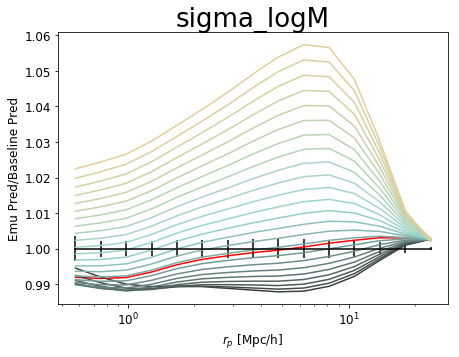

In [88]:
import matplotlib
from copy import deepcopy
font = {'size'   : 12}
matplotlib.rc('font', **font)

#fig = plt.figure(figsize=(15,6))
fig = plt.figure(figsize=(7,5))


varied_pname = 'sigma_logM'
lower, upper = emu.get_param_bounds(varied_pname)
#lower, upper = 0,200
baseline_params = true_param_dict
#baseline_params = MAP_dict
#baseline_params2 = deepcopy(true_param_dict)
#baseline_params2['H0'] = 71
#baseline_params2['omch2']=0.12
#baseline_params2['mean_occupation_centrals_assembias_param1'] = 0.45


for i in xrange(len(emus)):
    if i>0:
        break
    #plt.subplot(1,2,i+1)
    plt.errorbar(rbc, np.ones_like(true_data[i]), yerr=yerr/true_data[i], 
                 label = 'Data', color = 'k')

    pred = emus[i].emulate_wrt_r(baseline_params.copy()).squeeze()

    plt.plot(rbc, (10**pred)/true_data[i], label = 'Truth', color = 'r')    

    #pred = emus[i].emulate_wrt_r(baseline_params2.copy()).squeeze()

    #plt.plot(rbc, (10**pred)/true_data[i], label = 'Truth2', color = 'b')   
    
    plt.xscale('log')
    #plt.vlines(rmin, 0.8, 1.1, alpha = 0.6)
    plt.xlabel(r'$r_p$ [Mpc/h]')
    #if i == 0:
    #    plt.title(r'$w_p(r_p)$')
    #else:
    #    plt.title(r'$\Delta \Sigma(r_p)$')


for c, val in zip(cmap, np.linspace(lower, upper, N) ):
    param_dict = baseline_params.copy() #true_param_dict.copy()
    param_dict[varied_pname] = val

    for i in xrange(len(emus)):
        #plt.subplot(1,2,i+1)
        if i > 0:
            continue
        pred = emus[i].emulate_wrt_r(param_dict).squeeze()
        if i ==1:
            const = 1#np.power(val/(100*h), 2)
        else:
            const= 1 #np.power(val/(100*h), 1)
        plt.plot(rbc, const*((10**pred)/(true_data[i])), label = '%.3f'%val, color = c)

#plt.subplot(1,2,1)
plt.ylabel('Emu Pred/Baseline Pred')
#plt.subplot(1,2,2)

#plt.legend(loc='best')
plt.title(varied_pname, fontsize=26)
#plt.title(r'$\rho_{sat}$', fontsize=26)
#plt.ylim(0.95,1.05)

#plt.savefig('hsab_ratio.pdf', format='pdf', bbox_inches='tight')
#plt.savefig('corrab_ratio.pdf', format='pdf', bbox_inches='tight')

plt.show();

In [77]:
all_y = emu.y*emu._y_std+emu._y_mean

In [78]:
all_y.shape

(40, 1000, 15)

In [79]:
x1 = emu.x1*emu._x1_std+emu._x1_mean

In [80]:
emu.get_param_names()[:7]

['ombh2', 'omch2', 'w0', 'ns', 'H0', 'Neff', 'sigma8']

In [81]:
emu.get_param_names()[7:]

['mean_occupation_centrals_assembias_param1',
 'logM0',
 'sigma_logM',
 'mean_occupation_satellites_assembias_param1',
 'logM1',
 'alpha',
 'conc_gal_bias']

In [82]:
x1[0]

array([ 2.26832494e-02,  1.14059801e-01, -8.16597201e-01,  9.75588999e-01,
        6.33656900e+01,  2.91875000e+00,  7.73071500e-01])

In [83]:
fname = '/u/ki/swmclau2/des/Aemulators/knn_1_cdf_hsab/PearceKNN1CDFHSABCosmo.hdf5'

with h5py.File(fname, 'r') as f:
    kernel =  eval(f.attrs['lpw_kernel'])

In [84]:
kernel[0]

{'active_dims': [0, 1, 2, 3, 4, 5, 6],
 'class': 'GPy.kern.Add',
 'input_dim': 7,
 'name': 'sum',
 'parts': {0: {'ARD': True,
   'active_dims': [0, 1, 2, 3, 4, 5, 6],
   'class': 'GPy.kern.RBF',
   'input_dim': 7,
   'inv_l': False,
   'lengthscale': [15.782763610187814,
    2.7377902574284776,
    8.321485598758773,
    20.59827836485229,
    2.2300147511748794,
    18.55379012116235,
    1.4003976835412384],
   'name': 'rbf',
   'useGPU': False,
   'variance': [2.4587219989658213]},
  1: {'active_dims': [0, 1, 2, 3, 4, 5, 6],
   'class': 'GPy.kern.Bias',
   'input_dim': 7,
   'name': 'bias',
   'useGPU': False,
   'variance': [2.0930416281972497]}},
 'useGPU': False}

In [85]:
#emu._emulator.kern0.rbf.variance = 1.0
for i in xrange(7):
    emu._emulator.kern0.rbf.lengthscale[i]= kernel[0]['parts'][0]['lengthscale'][i]
    
emu._emulator.kern0.rbf.variance = kernel[0]['parts'][0]['variance'][0]#5.0

AttributeError: 'RBF' object has no attribute 'rbf'

In [ ]:
true_param_dict

In [ ]:
import matplotlib
font = {'size'   : 12}
matplotlib.rc('font', **font)

#fig = plt.figure(figsize=(15,6))
fig = plt.figure(figsize=(7,5))


varied_pname = 'omch2'
lower, upper = emu.get_param_bounds(varied_pname)
baseline_params = true_param_dict
#baseline_params = MAP_dict

for i in xrange(len(emus)):
    if i>0:
        break
    #plt.subplot(1,2,i+1)
    plt.errorbar(rbc, np.ones_like(true_data[i]), yerr=yerr[i]/true_data[i], 
                 label = 'Data', color = 'k')
    pred = emus[i].emulate_wrt_r(baseline_params.copy()).squeeze()
    if i ==1:
        const = 1#np.power(MAP_dict['H0']/(100*h), 2)
    else:
        const = 1
    #plt.plot(rbc, const*(10**pred)/true_data[i], label = 'Truth', color = 'k')    

    plt.xscale('log')
    #plt.vlines(rmin, 0.8, 1.1, alpha = 0.6)
    plt.xlabel(r'$r_p$ [Mpc/h]')
    #if i == 0:
    #    plt.title(r'$w_p(r_p)$')
    #else:
    #    plt.title(r'$\Delta \Sigma(r_p)$')


for c, val in zip(cmap, np.linspace(lower, upper, N) ):
    param_dict = baseline_params.copy() #true_param_dict.copy()
    param_dict[varied_pname] = val

    for i in xrange(len(emus)):
        #plt.subplot(1,2,i+1)
        if i > 0:
            continue
        pred = emus[i].emulate_wrt_r(param_dict).squeeze()
        if i ==1:
            const = 1#np.power(val/(100*h), 2)
        else:
            const= 1 #np.power(val/(100*h), 1)
        plt.plot(rbc, const*((10**pred)/(true_data[i])), label = '%.3f'%val, color = c)

#plt.subplot(1,2,1)
plt.ylabel('Emu Pred/Baseline Pred')
#plt.subplot(1,2,2)

plt.legend(loc='best')
plt.title(varied_pname, fontsize=26)
#plt.title(r'$\rho_{sat}$', fontsize=26)
#plt.ylim(0.95,1.05)

#plt.savefig('hsab_ratio.pdf', format='pdf', bbox_inches='tight')
#plt.savefig('corrab_ratio.pdf', format='pdf', bbox_inches='tight')

plt.show();

In [ ]:
assert False

In [ ]:
N = 100
cmap = sns.color_palette("BrBG_d", N)
rbin = 1
hod_idx = 235

In [ ]:
hod_dict = dict(zip(emu.get_param_names()[7:], (emu.x2*emu._x2_std+emu._x2_mean)[hod_idx]))

In [ ]:
hod_dict

In [ ]:
emu = emus[0]
y = (emu.y*emu._y_std+emu._y_mean)[:,hod_idx,rbin]

y_bar = y#.mean(axis = 1)
y_std = np.zeros_like(y)#.std(axis=1)

In [ ]:
y_bar.shape, y_std.shape

In [ ]:
idx = emu.get_param_names().index(varied_pname)

In [ ]:
emu.get_param_names()

In [ ]:
aem_vals = (emu.x1*emu._x1_std+emu._x1_mean)[:, idx]

In [ ]:
baseline_param2 = baseline_params.copy()
baseline_param2.update(hod_dict)

In [ ]:
np.argmin(y_bar)

In [ ]:
param_dict

In [ ]:
for c, val in zip(cmap, np.linspace(lower, upper, N) ):
    param_dict = baseline_param2.copy() #true_param_dict.copy()
    param_dict[varied_pname] = val

    plt.scatter(val,  emus[0].emulate_wrt_r(param_dict).squeeze()[rbin], color = c )
plt.errorbar(aem_vals, y_bar, yerr=y_std, fmt = 'o', color='r', ls = None)
    
plt.show() 

In [ ]:
assert False

In [ ]:
from pearce.mocks.kittens import TrainingBox
cat = TrainingBox(0)

In [ ]:
cat.load(1.0, 'hsabZheng07',\
         hod_kwargs = {'sec_haloprop_key':'halo_nfw_conc'})

In [ ]:
hod_params['mean_occupation_satellites_assembias_param1'] = 1.0
hod_params['mean_occupation_centrals_assembias_param1'] = 0.0

cat.populate(hod_params, min_ptcl = 20)
cat._add_logMmin(5e-4, min_ptcl = 20)

In [ ]:
r_bins = np.logspace(-1, 1.6, 19)

In [ ]:
wp_p1 = cat.calc_wp(r_bins)

In [ ]:
hod_params['mean_occupation_satellites_assembias_param1'] = -1.0
hod_params['mean_occupation_centrals_assembias_param1'] = 0.0
cat.populate(hod_params, min_ptcl = 20)
cat._add_logMmin(5e-4, min_ptcl = 20)

In [ ]:
wp_p2 = cat.calc_wp(r_bins)

In [ ]:
plt.plot(emu.scale_bin_centers, wp_p1/wp_p2)
plt.xscale('log')

In [ ]:
from pearce.mocks.kittens import Chinchilla

In [ ]:
cat = Chinchilla(400, 2048)

In [ ]:
cat.load(1.0, HOD='zheng07')

In [ ]:
from scipy.optimize import minimize_scalar
def add_logMmin(cat, hod_params):
    hod_params['logMmin'] = 13.0 #initial guess
    #cat.populate(hod_params) #may be overkill, but will ensure params are written everywhere
    def func(logMmin, hod_params):
        hod_params.update({'logMmin':logMmin})
        return (cat.calc_analytic_nd(hod_params, min_ptcl=20) - 5e-4)**2

    res = minimize_scalar(func, bounds = (12,15), args = (hod_params,), options = {'maxiter':100}, method = 'Bounded')

    # assuming this doens't fail
    print 'logMmin', res.x
    hod_params['logMmin'] = res.x

In [ ]:
add_logMmin(cat, hod_params)
r_bins = np.logspace(-1, 1.6, 19)

In [ ]:
N = 5
wps = np.zeros((N, 18))
for i in xrange(N):
    pritn i
    cat.populate(hod_params, min_ptcl=20)
    wps[i] = cat.calc_wp(r_bins)
    
wp = wps.mean(axis=0)
wp_err = wps.std(axis=0)

In [ ]:
chinchilla_pnames, chinchilla_pvals = cat._get_cosmo_param_names_vals()

In [ ]:
chinchilla_pnames

In [ ]:
cosmo_pnames = ['ombh2', 'omch2', 'w0', 'ns', 'H0', 'Neff', 'sigma8']
cosmo_true_vals = [chinchilla_pvals[1]*chinchilla_pvals[2]**2, (chinchilla_pvals[0]-chinchilla_pvals[1])*chinchilla_pvals[2]**2,
                   -1, chinchilla_pvals[4], 100*chinchilla_pvals[2], 3.046, chinchilla_pvals[3]]

cat_val_dict = dict(zip(cosmo_pnames, cosmo_true_vals))

In [ ]:
params = cat_val_dict.copy()
del hod_params['logMmin']
params.update(hod_params)

In [ ]:
emu_wp = 10**emus[0].emulate_wrt_r(params)[0]

In [ ]:
plt.plot(emu.scale_bin_centers, wp, label = 'Chinchilla')
plt.plot(emu.scale_bin_centers, emu_wp, label = 'Emu')
plt.legend(loc='best')
plt.loglog();

In [ ]:
plt.plot(emu.scale_bin_centers, wp/emu_wp)
plt.errorbar(emu.scale_bin_centers, np.ones_like(wp), yerr = wp_err/wp)
plt.xscale('log')

In [ ]:
plt.hist(cat.model.mock.galaxy_table['conc_NFWmodel'], bins = 100, normed = True);

In [ ]:
from pearce.mocks.kittens import TrainingBox

In [ ]:
cat2 = TrainingBox(0)
cat2.load(1.0, HOD='zheng07')

In [ ]:
add_logMmin(cat2, hod_params)
cat2.populate(hod_params, min_ptcl=20)

In [ ]:
bins = np.linspace(2.5, 20.0, 100)
plt.hist(cat.model.mock.galaxy_table['conc_NFWmodel'], bins = bins, normed = True, alpha = 0.3, label = 'Chinchilla');
plt.hist(cat2.model.mock.galaxy_table['conc_NFWmodel'], bins = bins, normed = True, alpha = 0.3, label = 'Aemulus');
plt.legend(loc='best')

In [ ]:
bins = np.linspace(-4, 0, 100)
plt.hist(np.log10(cat.halocat.halo_table['halo_rs']), bins = bins, normed=True, alpha = 0.3, label ='Chinchilla');
plt.hist(np.log10(cat2.halocat.halo_table['halo_rs']), bins = bins, normed=True, alpha = 0.3, label = 'Aemulus');
plt.legend(loc='best')

In [ ]:
bins = np.linspace(-4, 0, 100)
plt.hist(np.log10(cat.halocat.halo_table['halo_rvir']), bins = bins, normed=True, alpha = 0.3, label ='Chinchilla');
plt.hist(np.log10(cat2.halocat.halo_table['halo_rvir']), bins = bins, normed=True, alpha = 0.3, label = 'Aemulus');
plt.legend(loc='best')

In [ ]:
plt.hist2d(np.log10(cat.halocat.halo_table['halo_mvir']), np.log10(cat.halocat.halo_table['halo_rs']),\
           bins = 100, normed =True);
plt.hist2d(np.log10(cat2.halocat.halo_table['halo_mvir']), np.log10(cat2.halocat.halo_table['halo_rs']+1e-6),\
           bins = 100, normed =True);
plt.xlim([9, 13])
plt.ylim([-3, 0])

In [ ]:
m_min = np.min(cat2.halocat.halo_table['halo_mvir'])*10

In [ ]:
np.log10(m_min)

In [ ]:
mass_cut = np.logical_and(cat.halocat.halo_table['halo_mvir']>10**(12.0), cat.halocat.halo_table['halo_mvir']<10**(14.5))
mass_cut2 = np.logical_and(cat2.halocat.halo_table['halo_mvir']>10**(12.0), cat2.halocat.halo_table['halo_mvir']<10**(14.5)) 

In [ ]:
bins = np.linspace(11, 16, 100)
plt.hist(np.log10(cat.halocat.halo_table['halo_mvir'][mass_cut]), bins = bins, normed=True, alpha = 0.3, label ='Chinchilla');
plt.hist(np.log10(cat2.halocat.halo_table['halo_mvir'])[mass_cut2], bins = bins, normed=True, alpha = 0.3, label = 'Aemulus');
plt.legend(loc='best')

In [ ]:
1./0.01

In [ ]:
bins = np.linspace(1./0.2, 1./0.01, 50)
plt.hist(1./cat.halocat.halo_table['halo_rs'][mass_cut], bins = bins, normed=True, alpha = 0.3, label ='Chinchilla');
plt.hist(1./cat2.halocat.halo_table['halo_rs'][mass_cut2], bins = bins, normed=True, alpha = 0.3, label = 'Aemulus');
plt.legend(loc='best')

In [ ]:
bins = np.linspace(0.0, 1.0, 100)
plt.hist(cat.halocat.halo_table['halo_rvir'][mass_cut], bins = bins, normed=True, alpha = 0.3, label ='Chinchilla');
plt.hist(cat2.halocat.halo_table['halo_rvir'][mass_cut2], bins = bins, normed=True, alpha = 0.3, label = 'Aemulus');
plt.legend(loc='best')

In [ ]:
bins = np.linspace(2.5, 20, 100)
plt.hist(cat.halocat.halo_table['halo_nfw_conc'][mass_cut], bins = bins, normed=True, alpha = 0.3, label ='Chinchilla');
plt.hist(cat2.halocat.halo_table['halo_nfw_conc'][mass_cut2], bins = bins, normed=True, alpha = 0.3, label = 'Aemulus');
plt.legend(loc='best')
#plt.yscale('log')

In [ ]:
finite_idxs = np.isfinite(cat2.halocat.halo_table['halo_nfw_conc'])
mass_cut2 = np.logical_and(finite_idxs, mass_cut2)

In [ ]:
sns.jointplot(np.log10(cat2.halocat.halo_table['halo_mvir'][mass_cut2]), np.log10(1./cat2.halocat.halo_table['halo_rs'][mass_cut2]), kind='hex')

In [ ]:
sns.jointplot(np.log10(cat.halocat.halo_table['halo_mvir'][mass_cut]), np.log10(1./cat.halocat.halo_table['halo_rs'][mass_cut]), kind='hex')

In [ ]:
sns.jointplot(cat2.halocat.halo_table['halo_rvir'][mass_cut2], np.log10(cat2.halocat.halo_table['halo_mvir'][mass_cut2]), kind='hex')

In [ ]:
sns.jointplot(cat.halocat.halo_table['halo_rvir'][mass_cut], np.log10(cat.halocat.halo_table['halo_mvir'][mass_cut]), kind='hex')